# Amplitude

**in-vivo**:

* `Horvath`
    * rat
    * rectangular contact of 20 um side, see (2,3)
    * 128ch 
    * 20.0kHz
    * 3688.668s (1h)
    * "Spontaneous activity" (Only anesthetized condition)
    * questions: do we metadata for Horvath? were some of the contacts discarded?
    
* `[TODO]: Add Allen mice neuropixels`

**in-silico**:

* `npx384`
    * activity simulated for 7 columns (hex_O1) 
    * 10 min-ish
    * 40 KHz
    * 384 contacts     
    * list of channels clearly in the microcircuit:
        - 30-70; 125-165; 221-261; 316-256
* `buccino 2020`
    * answers to question on if we are more realistic than existing models
    * 384 contacts
    * 32 KHz 
    * 10 min (600 secs)
    * activity is simulated on all contacts
    * "spontaneous activity" condition
    * elife
* `npx32` 
    * answers to question on the role of mesoscale lateral connections
    * (10 min-ish)

Backlogged:

**in-vivo**
* `Reyes` (Backlogged for now, waiting for Milo's help) 
    * rat
    * neuronexus probe (circular contact of 10 um radius, see (1))
    * 18ch
    * 20.0kHz
    * 4385.500s (1.2h)
    * Serie 1, Exp09, File 2: 
        * "C2 whisker stimulation" (see metadata, Block 0:1000 in "20_selected_files_16by1.xlsx") 
        * "spontaneous activity" (see metadata, Block 1000:4300) 

TODO:
-  compare to Buccino dataset and other real datasets (mice neuropixels etc ..) of spontaneous activity


### Setup libs

Activate `npx_10m_384ch_unit_classes` venv

In [21]:
# import libs
%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import scipy
import spikeinterface.extractors as se 
import os
import spikeinterface as si
import spikeinterface.preprocessing as spre
import shutil 

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/bernstein_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.study import amplitude

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup datasets

Reyes is on hold. The traces currently contain whisker stimulation periods, not spontaneous only. Waiting for Milo's help to interpret the metadata.

In [2]:
# REYES (real): 

EXPERIMENT_reyes = "vivo_reyes"
SIMULATION_DATE_reyes = "2015"
data_conf_reyes, _ = get_config(EXPERIMENT_reyes, SIMULATION_DATE_reyes).values()
RAW_RECORDING_PATH_reyes = data_conf_reyes["recording"]["output"]
PREPRO_PATH_REYES = data_conf_reyes["preprocessing"]["output"]["trace_file_path"]
POWER_PATH_REYES = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/realism/power/reyes/"
N_CONTACTS_REYES = 16
SAMP_FREQ_REYES = 20000
CONTACTS_IN_CIRCUIT_reyes = np.arange(0, 16, 1)
AMPLITUDE_TO_NOISE_PATH_REYES = data_conf_reyes["features"]["trace"]["amplitude_to_noise_ratio"]

# HORVATH (real)

DATA_PATH_horvath = "/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/dataset/horvath/Rat01/Insertion1/Depth2/Rat01_Insertion1_Depth2.nwb"
PREPRO_PATH_horvath = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/preprocessed/horvath/traces"
CONTACTS_IN_CIRCUIT_horvath = np.arange(0, 128, 1)
AMPLITUDE_TO_NOISE_PATH_HORVATH = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/features/1_vivo/horvath/amplitude_to_noise_ratio.npy"

# NPX-32CH-simulated_hex_O (our silico)

EXPERIMENT_32 = "silico_neuropixels"
SIMULATION_DATE_32 = "2023_02_19"
data_conf_32, param_conf_32 = get_config(EXPERIMENT_32, SIMULATION_DATE_32).values() # confs
RAW_RECORDING_PATH_32 = data_conf_32["recording"]["output"]
PREPRO_PATH_32 = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/preprocessed/npx32/traces"
CHANNEL_ID_32 = 0 # set channel
N_CONTACTS_32 = 32
CONTACTS_IN_CIRCUIT_npx32 = np.arange(0, 32, 1)
AMPLITUDE_TO_NOISE_PATH_32 = data_conf_32["features"]["trace"]["amplitude_to_noise_ratio"]

# NPX-384CH-simulated_hex_O1 (our silico)

EXPERIMENT_384 = "silico_neuropixels"
SIMULATION_DATE_384 = "2023_08_17"
data_conf_384, param_conf_384 = get_config(EXPERIMENT_384, SIMULATION_DATE_384).values()
RAW_RECORDING_PATH_384 = data_conf_384["recording"]["output"]
PREPRO_PATH_384 = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/preprocessed/npx384/traces"
CONTACTS_IN_CIRCUIT_npx384 = np.hstack([np.arange(30, 71, 1), np.arange(125, 166, 1), np.arange(221, 262,1), np.arange(316, 257,1)])
AMPLITUDE_TO_NOISE_PATH_384 = data_conf_384["features"]["trace"]["amplitude_to_noise_ratio"]

# Buccino 2020 simulation (silico)

EXPERIMENT_bucci = "buccino_2020"
SIMULATION_DATE_bucci = "2020"
data_conf_bucci, _ = get_config(EXPERIMENT_bucci, SIMULATION_DATE_bucci).values()
RAW_RECORDING_PATH_bucci = data_conf_bucci["recording"]["input"]
PREPRO_PATH_bucci= "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/preprocessed/buccino2020/traces"
CONTACTS_IN_CIRCUIT_bucci = np.arange(0, 384, 1)
AMPLITUDE_TO_NOISE_PATH_BUCCI = data_conf_bucci["features"]["trace"]["amplitude_to_noise_ratio"]

2023-09-18 18:27:06,503 - root - utils.py - get_config - INFO - Reading experiment config.
2023-09-18 18:27:06,516 - root - utils.py - get_config - INFO - Reading experiment config. - done


2023-09-18 18:27:06,518 - root - utils.py - get_config - INFO - Reading experiment config.
2023-09-18 18:27:06,546 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-09-18 18:27:06,547 - root - utils.py - get_config - INFO - Reading experiment config.
2023-09-18 18:27:06,584 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-09-18 18:27:06,585 - root - utils.py - get_config - INFO - Reading experiment config.
2023-09-18 18:27:06,596 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Amplitude-to-max-amplitude ratio

#### Process traces

- A lfp trace of 87,710,000 timepoints takes 2 min to plot.
- We normalize the traces between 0 and 1 to get rid of the different voltage amplification used. This allows a fair comparison between trace amplitude distribution. This relies on the assumptions that
    - the electrodes' contacts have different radii (10/20 um for reyes/horvath) but that the effect on the measured voltage amplitude is small (about 0.2 mv, see Hagen, Fig 4b, JNMethods, 2015)
        - all trace will have the same minimum absolute voltage of 0. Our normalization allow to compare how fast amplitude distributions fall from their common peak at 0, which analysis relies on no assumption.
    -  all traces, if long enough, converge to the same single-unit maximum amplitude (because isolatable single-units are within the same distance to the electrode).

    

In [4]:
## re-preprocess traces (takes 1 hour)
# horvath_recording_pre = amplitude.preprocess_horvath(DATA_PATH_horvath, PREPRO_PATH_horvath, freq_min=300, freq_max=4999)
# recording_pre_384 = amplitude.preprocess_silico(RAW_RECORDING_PATH_384, PREPRO_PATH_384, freq_min=300, freq_max=4999)
# recording_pre_bucci = amplitude.preprocess_silico(RAW_RECORDING_PATH_bucci, PREPRO_PATH_bucci, freq_min=300, freq_max=4999)
# recording_pre_32 = amplitude.preprocess_silico(RAW_RECORDING_PATH_32, PREPRO_PATH_32, freq_min=300, freq_max=4999)

is filtered: True
write_binary_recording with n_jobs = 1 and chunk_size = None


In [4]:
## load and normalize to max to 1 (for fair comparison with other traces)
reyes_recording_pre = si.load_extractor(PREPRO_PATH_REYES)
horvath_recording_pre = si.load_extractor(PREPRO_PATH_horvath)
recording_pre_384 = si.load_extractor(PREPRO_PATH_384)
recording_pre_bucci = si.load_extractor(PREPRO_PATH_bucci)
recording_pre_32 = si.load_extractor(PREPRO_PATH_32)

#### Plot 

We normalized amplitudes by dividing them by contact's maximum amplitude to enable comparison between datasets. We plot normalized amplitudes averaged over contacts with their 95% confidence interval.

In [7]:
# takes 10 mins

# compute

# reyes 
dist_mean_reyes, dist_ci_reyes, bins_reyes = amplitude.compute_proba_dist_stats(reyes_recording_pre, CONTACTS_IN_CIRCUIT_reyes, abs=True) 

# Horvath 6 mins
dist_mean_horvath, dist_ci_horvath, bins_horvath = amplitude.compute_proba_dist_stats(horvath_recording_pre, CONTACTS_IN_CIRCUIT_horvath, abs=True) 

# npx384 (takes 3 mins)
dist_mean_npx384, dist_ci_npx384, bins_npx384 = amplitude.compute_proba_dist_stats(recording_pre_384, CONTACTS_IN_CIRCUIT_npx384, abs=True) 

# bucci (takes .. mins)
dist_mean_bucci, dist_ci_bucci, bins_bucci = amplitude.compute_proba_dist_stats(recording_pre_bucci, CONTACTS_IN_CIRCUIT_bucci, abs=True) 

# npx32 (takes .. mins)
dist_mean_npx32, dist_ci_npx32, bins_npx32 = amplitude.compute_proba_dist_stats(recording_pre_32, CONTACTS_IN_CIRCUIT_npx32, abs=True) 

In [8]:
# unit-test
assert 1-sum(dist_mean_reyes) < 1e-15, "a proba dist. should sum to 1"
assert 1-sum(dist_mean_horvath) < 1e-15, "a proba dist. should sum to 1"
assert 1-sum(dist_mean_npx384) < 1e-15, "a proba dist. should sum to 1"
assert 1-sum(dist_mean_bucci) < 1e-15, "a proba dist. should sum to 1"
assert 1-sum(dist_mean_npx384) < 1e-15, "a proba dist. should sum to 1"

* we plot on logscale because the amplitude probability dist. decays exponentially, which is not visible on a linear scale.
* we plot the top ci only (because bottom ci go to infinity (when negative) on a logscale)

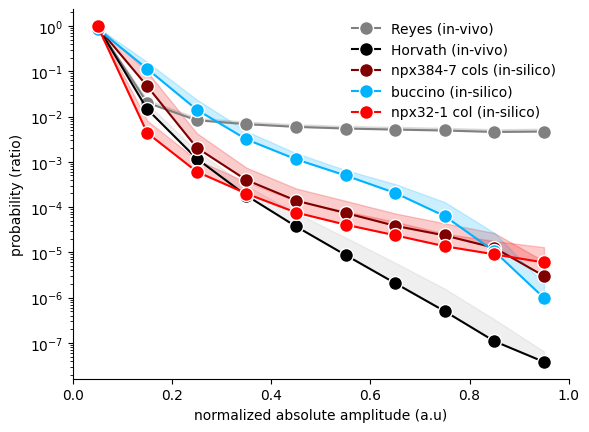

In [10]:
# takes 8 secs
fig_, axis = plt.subplots(1,1)

amplitude.plot_proba_dist_stats(axis, dist_mean_reyes, dist_ci_reyes, bins_reyes, color=[.5,.5,.5], ci_color=[.5,.5,.5], label="Reyes (in-vivo)")
amplitude.plot_proba_dist_stats(axis, dist_mean_horvath, dist_ci_horvath, bins_horvath, color=[0,0,0], ci_color=[.7,.7,.7], label="Horvath (in-vivo)")
amplitude.plot_proba_dist_stats(axis, dist_mean_npx384, dist_ci_npx384, bins_npx384, color=[.5,0,0], ci_color=[.9,0,0], label="npx384-7 cols (in-silico)")
amplitude.plot_proba_dist_stats(axis, dist_mean_bucci, dist_ci_bucci, bins_bucci, color=[0,.7,1], ci_color=[0,.7,1], label="buccino (in-silico)")
amplitude.plot_proba_dist_stats(axis, dist_mean_npx32, dist_ci_npx32, bins_npx32, color=[1,0,0], ci_color=[1,0,0], label="npx32-1 col (in-silico)")

# legend 
axis.set_yscale("log");
axis.legend(frameon=False);
axis.set_xlim([0, 1]);
axis.spines[['right', 'top']].set_visible(False);
axis.set_ylabel("probability (ratio)");
axis.set_xlabel("normalized absolute amplitude (a.u)");

# save
plt.savefig("figures/2_realism/2_amplitude/amplitude_comp.pdf"); # pdf
plt.savefig("figures/2_realism/2_amplitude/amplitude_comp.svg"); # svgb

### Amplitude-to-noise ratio (ANR)

Large outlier amplitudes will have substantial impact on lower normalized amplitudes with the above normalization approach. To make our amplitude robust to outliers, so we calculated an amplitude-to-noise ratio by normalizing the amplitudes by the mean absolute deviation of the traces.

Compute ANR and save

In [11]:
# # takes 20 mins (uncomment to rerun)

# # reyes
# anr_reyes = amplitude.compute_anr(reyes_recording_pre, CONTACTS_IN_CIRCUIT_reyes)

# # horvath
# anr_horvath = amplitude.compute_anr(horvath_recording_pre, CONTACTS_IN_CIRCUIT_horvath)

# # npx384
# anr_384 = amplitude.compute_anr(recording_pre_384, CONTACTS_IN_CIRCUIT_npx384)

# # npx32
# anr_32 = amplitude.compute_anr(recording_pre_32, CONTACTS_IN_CIRCUIT_npx32)

# # buccino
# anr_bucci = amplitude.compute_anr(recording_pre_bucci, CONTACTS_IN_CIRCUIT_bucci)

# # SAVE: takes 1 min

# parent_path = os.path.dirname(AMPLITUDE_TO_NOISE_PATH_REYES)
# if not os.path.isdir(parent_path):
#     os.makedirs(parent_path)
# np.save(AMPLITUDE_TO_NOISE_PATH_REYES, anr_reyes, allow_pickle=True)

# parent_path = os.path.dirname(AMPLITUDE_TO_NOISE_PATH_HORVATH)
# if not os.path.isdir(parent_path):
#     os.makedirs(parent_path)
# np.save(AMPLITUDE_TO_NOISE_PATH_HORVATH, anr_horvath, allow_pickle=True)

# parent_path = os.path.dirname(AMPLITUDE_TO_NOISE_PATH_384)
# if not os.path.isdir(parent_path):
#     os.makedirs(parent_path)
# np.save(AMPLITUDE_TO_NOISE_PATH_384, anr_384, allow_pickle=True)

# parent_path = os.path.dirname(AMPLITUDE_TO_NOISE_PATH_32)
# if not os.path.isdir(parent_path):
#     os.makedirs(parent_path)
# np.save(AMPLITUDE_TO_NOISE_PATH_32, anr_32, allow_pickle=True)

# parent_path = os.path.dirname(AMPLITUDE_TO_NOISE_PATH_BUCCI)
# if not os.path.isdir(parent_path):
#     os.makedirs(parent_path)
# np.save(AMPLITUDE_TO_NOISE_PATH_BUCCI, anr_bucci, allow_pickle=True)

/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/bernstein_2023/src/nodes/study/amplitude.py:172: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = pd.DataFrame(trace_i).mad().values


In [3]:
# takes 1 min

# load
anr_reyes = np.load(AMPLITUDE_TO_NOISE_PATH_REYES)
anr_horvath = np.load(AMPLITUDE_TO_NOISE_PATH_HORVATH)
anr_384 = np.load(AMPLITUDE_TO_NOISE_PATH_384)
anr_32 = np.load(AMPLITUDE_TO_NOISE_PATH_32)
anr_bucci = np.load(AMPLITUDE_TO_NOISE_PATH_BUCCI)

Calculate common bin across datasets

In [4]:
# takes 4 mins

N_BINS = 30

# calculate common bin across dataset
anr_all = np.hstack([np.array(anr_reyes).flatten(), np.array(anr_32).flatten(), np.array(anr_384).flatten(), np.array(anr_horvath).flatten(), np.array(anr_bucci).flatten()])
anr_max = np.max(anr_all)
anr_min = np.min(anr_all)
step = (anr_max - anr_min) / N_BINS
bins = np.arange(anr_min, anr_max + step/2, step)

Compute probability distribution stats over contacts

In [5]:
# takes 4 min 

# reyes
dist_mean_reyes, dist_ci_reyes = amplitude.compute_anr_proba_dist_stats(anr_reyes, bins)

# horvath
dist_mean_horvath, dist_ci_horvath = amplitude.compute_anr_proba_dist_stats(anr_horvath, bins)

# npx384
dist_mean_384, dist_ci_384 = amplitude.compute_anr_proba_dist_stats(anr_384, bins)

# npx32
dist_mean_32, dist_ci_32 = amplitude.compute_anr_proba_dist_stats(anr_32, bins)

# buccino
dist_mean_bucci, dist_ci_bucci = amplitude.compute_anr_proba_dist_stats(anr_bucci, bins)

In [6]:
# unit-test
assert 1-sum(dist_mean_horvath) < 1e-15, "a proba dist. should sum to 1"
assert 1-sum(dist_mean_32) < 1e-15, "a proba dist. should sum to 1"
assert 1-sum(dist_mean_bucci) < 1e-15, "a proba dist. should sum to 1"
assert 1-sum(dist_mean_384) < 1e-15, "a proba dist. should sum to 1"

Plot

The dots below the x-axis line goes to -inf on a log scale because they are never observed (probability = 0)

/tmp/ipykernel_44422/2820551726.py:21: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axis.set_ylim([-1, 1]);


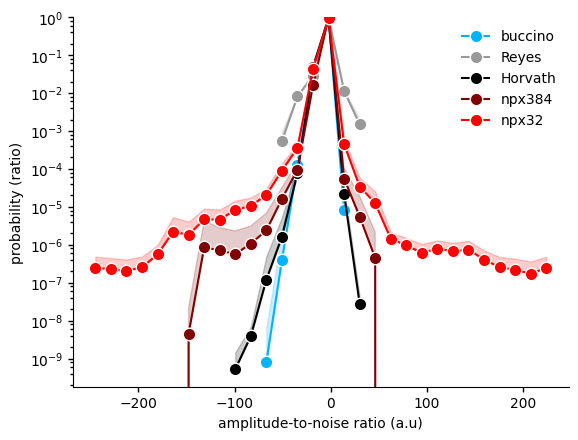

In [23]:
# plot
fig_, axis = plt.subplots(1,1)

# buccino
amplitude.plot_proba_dist_stats(axis, dist_mean_bucci[dist_mean_bucci>0], dist_ci_bucci[dist_mean_bucci>0], bins[:-1][dist_mean_bucci>0], color=[0,.7,1], ci_color=[0,.7,1], label="buccino")

# horvath
amplitude.plot_proba_dist_stats(axis, dist_mean_reyes[dist_mean_reyes>0], dist_ci_reyes[dist_mean_reyes>0], bins[:-1][dist_mean_reyes>0], color=[.6,.6,.6], ci_color=[.6,.6,.6], label="Reyes")

# horvath
amplitude.plot_proba_dist_stats(axis, dist_mean_horvath[dist_mean_horvath>0], dist_ci_horvath[dist_mean_horvath>0], bins[:-1][dist_mean_horvath>0], color=[0,0,0], ci_color=[0,0,0], label="Horvath")

# npx384
amplitude.plot_proba_dist_stats(axis, dist_mean_384, dist_ci_384, bins[:-1], color=[.5,0,0], ci_color=[.5,0,0], label="npx384")

# npx32
amplitude.plot_proba_dist_stats(axis, dist_mean_32, dist_ci_32, bins[:-1], color=[1,0,0], ci_color=[1,0,0], label="npx32")

# legend 
axis.set_yscale("log");
axis.set_ylim([-1, 1]);
# axis.legend(frameon=False);
axis.spines[['right', 'top']].set_visible(False);
axis.set_ylabel("probability (ratio)");
axis.set_xlabel("amplitude-to-noise ratio (a.u)");
axis.tick_params(which='both', width=1)

# show minor ticks
axis.tick_params(which='major', width=1)
# y
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=12) 
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=12)
axis.yaxis.set_major_locator(locmaj)    
axis.yaxis.set_minor_locator(locmin)
axis.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# save
plt.savefig("figures/2_realism/2_amplitude/amplitude_to_noise.pdf"); # pdf
plt.savefig("figures/2_realism/2_amplitude/amplitude_to_noise.svg"); # svg

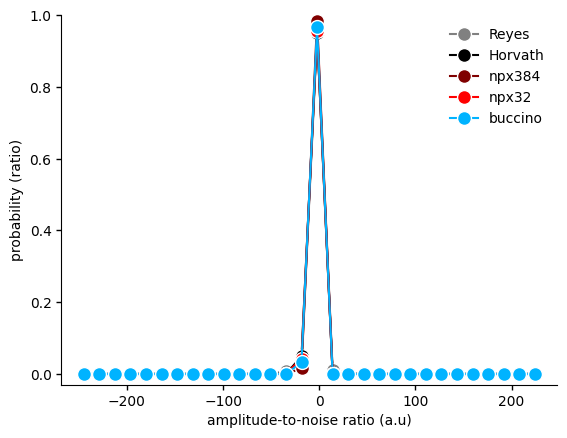

In [27]:
# plot
fig_, axis = plt.subplots(1,1)

# buccino
amplitude.plot_proba_dist_stats(axis, dist_mean_bucci, dist_ci_bucci, bins, color=[0,.7,1], ci_color=[0,.7,1], label="buccino")

# horvath
amplitude.plot_proba_dist_stats(axis, dist_mean_reyes, dist_ci_reyes, bins, color=[.5,.5,.5], ci_color=[.5,.5,.5], label="Reyes")

# horvath
amplitude.plot_proba_dist_stats(axis, dist_mean_horvath, dist_ci_horvath, bins, color=[0,0,0], ci_color=[.7,.7,.7], label="Horvath")

# npx384
amplitude.plot_proba_dist_stats(axis, dist_mean_384, dist_ci_384, bins, color=[.5,0,0], ci_color=[.9,0,0], label="npx384")

# npx32
amplitude.plot_proba_dist_stats(axis, dist_mean_32, dist_ci_32, bins, color=[1,0,0], ci_color=[1,0,0], label="npx32")

# legend 
axis.set_ylim([-0.03, 1]);
axis.legend(frameon=False);
axis.spines[['right', 'top']].set_visible(False);
axis.set_ylabel("probability (ratio)");
axis.set_xlabel("amplitude-to-noise ratio (a.u)");
axis.tick_params(which='both', width=1)

# References

(1) https://gin.g-node.org/spikeinterface/probeinterface_library/src/master/neuronexus/A1x32-Poly3-10mm-50-177/A1x32-Poly3-10mm-50-177.json

(2) Horváth et al., “Dataset of Cortical Activity Recorded with High Spatial Resolution from Anesthetized Rats.”

(3) Fiáth, R., Raducanu, B. C., Musa, S., Andrei, A., Lopez, C. M., Van Hoof, C., ... & Ulbert, I. (2018). A silicon-based neural probe with densely-packed low-impedance titanium nitride microelectrodes for ultrahigh-resolution in vivo recordings. Biosensors and Bioelectronics, 106, 86-92.  